In [1]:
import os, cv2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import plotting, get_segments, crop

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
dataset_dir = "./Dataset/frames/frames/"

In [4]:
files = os.listdir(dataset_dir)

# Workflow Start

In [5]:
image = cv2.imread(os.path.join(dataset_dir, files[0]))

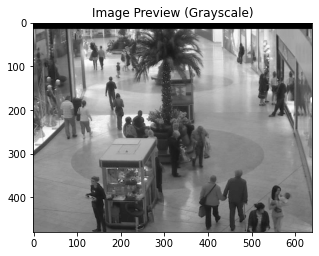

In [6]:
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plotting(gray, "Image Preview (Grayscale)")

In [7]:
# Read image
im_norm = np.float32(gray) / 255.0

# Calculate gradient
gx = cv2.Sobel(im_norm, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(im_norm, cv2.CV_32F, 0, 1, ksize=1)

In [8]:
# Python Calculate gradient magnitude and direction ( in degrees )
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

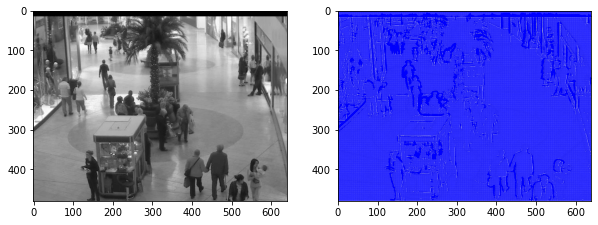

In [9]:
plt.figure(figsize=(10,5))

# display the image
plt.subplot(1,2,1)
plt.imshow(gray, cmap='gray')

# display the magnitude of the gradients:
plt.subplot(1,2,2)
plt.imshow(mag, cmap='binary')
# and superimpose an arrow showing the gradient
# magnitude and direction: 
q = plt.quiver(gx, gy, color='blue')
# plt.savefig('gradient.png')
plt.show()

This above method shows that HOG cannot be applied on the image completely.

Lets try by segmenting the images

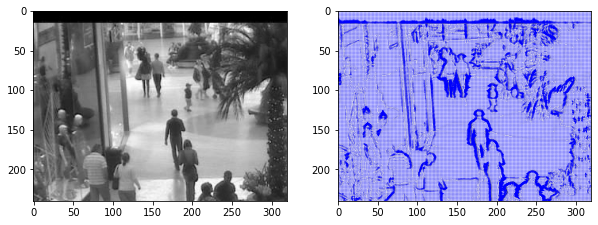

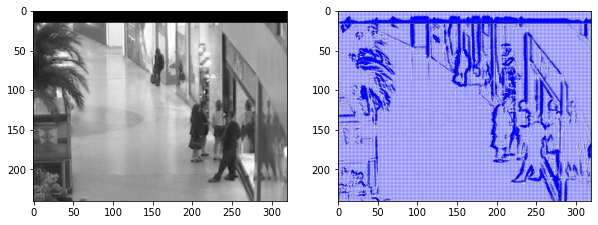

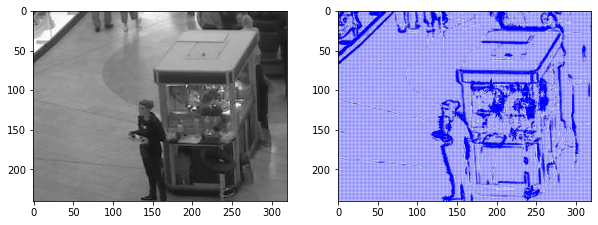

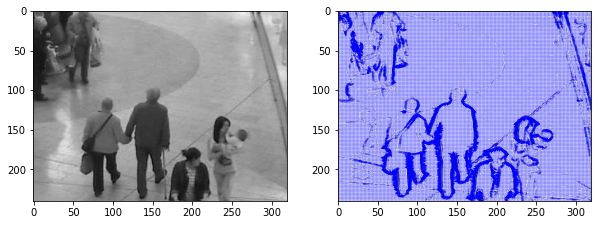

In [10]:
img_segments = get_segments(gray)
for seg in img_segments:
    im_norm = np.float32(seg) / 255.0
    gx = cv2.Sobel(im_norm, cv2.CV_32F, 1, 0, ksize=1)
    gy = cv2.Sobel(im_norm, cv2.CV_32F, 0, 1, ksize=1)
    mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)

    plt.figure(figsize=(10,5))

    # display the image
    plt.subplot(1,2,1)
    plt.imshow(seg, cmap='gray')

    # display the magnitude of the gradients:
    plt.subplot(1,2,2)
    plt.imshow(mag, cmap='binary')
    # and superimpose an arrow showing the gradient
    # magnitude and direction: 
    q = plt.quiver(gx, gy, color='blue')
    # plt.savefig('gradient.png')
    plt.show()

Lets now use the HOG Descriptor trained on SVM

In [11]:
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

In [12]:
img_trial = image.copy()
(rects, weights) = hog.detectMultiScale(img_trial, winStride=(8,8))
rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
for (xA, yA, xB, yB) in rects:
    cv2.rectangle(img_trial, (xA, yA), (xB, yB), (0, 255, 0), 2)

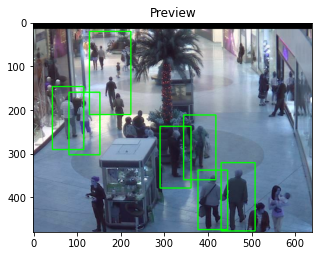

In [13]:
plotting(img_trial, "Preview")

Applying HOG on complete image can miss out some people here.
We can apply 2 methods here:
1. Segment the images into 4 quadrants and detect people in them
2. Use complete image to get initial count. Once we have the rectangles, we can use these reactangles to crop them and find out more people within them

Applying Operation 1

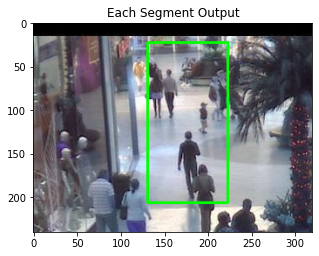

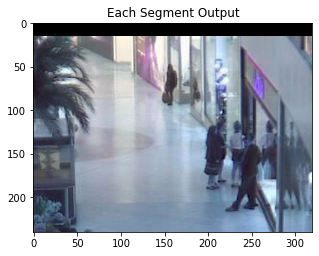

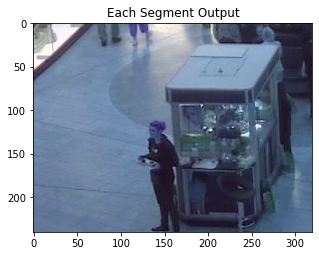

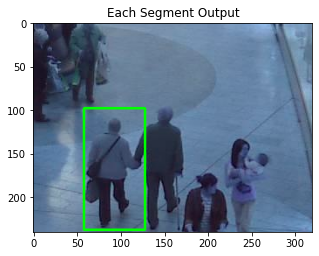

In [14]:
img_segments = get_segments(image)
for seg in img_segments:
    (rects, weights) = hog.detectMultiScale(seg, winStride=(8,8))
    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
    for (xA, yA, xB, yB) in rects:
        cv2.rectangle(seg, (xA, yA), (xB, yB), (0, 255, 0), 2)

    plotting(seg, "Each Segment Output")

Working with image segments will not help with understanding the complete count of people in the image.

We will now look into the second method to apply HOG on the boxes already present on the original image

In [19]:
def detect_human(image):
    (rects, weights) = hog.detectMultiScale(image, winStride=(4, 4))
    return rects

def get_all_people_bounds(image):
    all_rects = []
    rects = detect_human(image)
    all_rects.extend(rects)
    if len(rects) == 0:
        return []

    for (x, y, w, h) in rects:
        rect_img = crop(image, y, y+h, x, x+w)
        rects_img = get_all_people_bounds(rect_img)
        all_rects.extend(rects_img)

    return all_rects    

def get_people_count(image):
    rects = get_all_people_bounds(image)
    rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in rects])
    for (xA, yA, xB, yB) in rects:
        cv2.rectangle(image, (xA, yA), (xB, yB), (0, 255, 0), 2)

    return count, image        

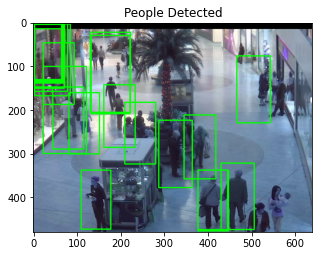

Total Count : 25


In [20]:
count, out_image = get_people_count(image)
plotting(out_image, "People Detected")
print(f"Total Count : {count}")